In [1]:
# %%
import os


os.environ["JAX_PLATFORMS"] = "cuda"  # change to 'cpu' if no GPU is available


from datasets import load_dataset

import grain

import jax
from jax import numpy as jnp

import numpy as np

from flax import nnx

from gensbi.experimental.models.autoencoders import AutoEncoder1D, AutoEncoderParams, vae_loss_fn
from gensbi.experimental.models.autoencoders.commons import Loss

import optax

from tqdm import tqdm

import matplotlib.pyplot as plt

from gensbi.utils.plotting import plot_marginals
import gc

In [2]:
repo_name = "aurelio-amerio/SBI-benchmarks"

task_name = "gravitational_waves"

# dataset = load_dataset(repo_name, task_name).with_format("numpy")
dataset = load_dataset(repo_name, task_name, cache_dir="/data/users/.cache").with_format("numpy")


Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [3]:
# df_train = {"xs": np.array(dataset["train"]["xs"]), "thetas": np.array(dataset["train"]["thetas"])}
# df_val = {"xs": np.array(dataset["validation"]["xs"]), "thetas": np.array(dataset["validation"]["thetas"])}
# df_test = {"xs": np.array(dataset["test"]["xs"]), "thetas": np.array(dataset["test"]["thetas"])}
df_train = dataset["train"]
df_val = dataset["validation"]
df_test = dataset["test"]

In [4]:
dim_obs = 1
dim_cond = 8192
ch_obs = 2
ch_cond = 2
z_ch = 128

In [5]:
# compute the mean of xs and thetas
xs_mean = jnp.array([[[ 0.00051776, -0.00040733]]], dtype=jnp.bfloat16) #np.mean(df_train["xs"], axis=(0,1), keepdims=True)
thetas_mean = jnp.array([[44.826576, 45.070328]], dtype=jnp.bfloat16) #np.mean(df_train["thetas"], axis=0, keepdims=True)

xs_std = jnp.array([[[60.80799, 59.33193]]], dtype=jnp.bfloat16) #np.std(df_train["xs"], axis=(0,1), keepdims=True)
thetas_std = jnp.array([[20.189356, 20.16127 ]], dtype=jnp.bfloat16) #np.std(df_train["thetas"], axis=0, keepdims=True)



W0104 23:02:12.502824 2133612 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0104 23:02:12.508970 2133452 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [6]:
def normalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return (batch - mean) / std

def unnormalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return batch * std + mean

In [7]:
ae_params = AutoEncoderParams(
        resolution=dim_cond,
        in_channels=ch_cond,
        ch=32,
        out_ch=ch_cond,
        ch_mult=[
            1,  # 8192
            2,  # 4096
            4,  # 2048
            8,  # 1024
            16,  # 512
            16,  # 256
            16,  # 128
            16,  # 64
            16, # 32
            16, # 16
            16, # 8
            16, # 4
        ],
        num_res_blocks=1,
        z_channels=z_ch,
        scale_factor=0.3611,
        shift_factor=0.1159,
        rngs=nnx.Rngs(42),
        param_dtype=jnp.bfloat16,
    )

In [8]:
vae_model = AutoEncoder1D(ae_params)

In [9]:
vae_model.decoder = None
gc.collect()

48

# now we create the flow pipeline

In [10]:
from gensbi.models import Flux1Params, Flux1
from gensbi.recipes import ConditionalFlowPipeline

from jax import Array

In [11]:
dim_obs = 2
dim_cond = 8192
ch_obs = 1
ch_cond = 2
dim_cond_latent = vae_model.latent_shape[1]
dim_joint = dim_obs + dim_cond_latent


In [12]:
params_flux = Flux1Params(
        in_channels=ch_obs,
        vec_in_dim=None,
        context_in_dim=z_ch,
        mlp_ratio=4,
        num_heads=4,
        depth=4,
        depth_single_blocks=8,
        axes_dim=[
            8, 2
        ],
        dim_obs=dim_obs,
        dim_cond=dim_cond_latent,
        theta = 10*dim_joint,
        qkv_bias=True,
        guidance_embed=False,
        use_rope = (False, True), # do not use rope for obs, use rope for cond
        rngs=nnx.Rngs(0),
        param_dtype=jnp.bfloat16,
    )

In [13]:
model_sbi = Flux1(params_flux)

In [14]:
# now we create a model which joins the vae encoder and the sbi model
# first we delete the decoder, as we won't need it 


In [15]:
class GWModel(nnx.Module):
    def __init__(self, vae, sbi_model):
        self.vae = vae
        self.sbi_model = sbi_model
        
    def __call__(self, 
                    t: Array,
                    obs: Array,
                    obs_ids: Array,
                    cond: Array,
                    cond_ids: Array,
                    conditioned: bool | Array = True,
                    guidance: Array | None = None,
                    encoder_key = None):
        
        # first we encode the conditioning data
        cond_latent = self.vae.encode(cond, encoder_key)
        
        # then we pass to the sbi model
        return self.sbi_model(
            t=t,
            obs=obs,
            obs_ids=obs_ids,
            cond=cond_latent,
            cond_ids=cond_ids,
            conditioned=conditioned,
            guidance=guidance,
        )

In [16]:
model = GWModel(vae_model, model_sbi)

In [17]:
def split_data(batch):
    obs = jnp.array(batch["thetas"], dtype=jnp.bfloat16)
    obs = normalize(obs, thetas_mean, thetas_std)
    obs = obs.reshape(obs.shape[0], dim_obs, ch_obs)
    cond = jnp.array(batch["xs"], dtype=jnp.bfloat16)
    cond = normalize(cond, xs_mean, xs_std)
    return obs, cond

In [18]:
batch_size = 128

train_dataset_npe = (
        grain.MapDataset.source(df_train)
        .shuffle(42)
        .repeat()
        .to_iter_dataset()
    )

performance_config = grain.experimental.pick_performance_config(
    ds=train_dataset_npe,
    ram_budget_mb=1024 * 8,
    max_workers=None,
    max_buffer_size=None,
)

train_dataset_npe = (
    train_dataset_npe.batch(batch_size)
    .map(split_data)
    # .mp_prefetch(performance_config.multiprocessing_options)
)

val_dataset_npe = (
            grain.MapDataset.source(df_val)
            .shuffle(42)
            .repeat()
            .to_iter_dataset()
            .batch(batch_size)
            .map(split_data)
        )

In [19]:
iter_train_npe = iter(train_dataset_npe)
obs_, cond_ = next(iter_train_npe)

In [20]:
training_config = ConditionalFlowPipeline.get_default_training_config()
training_config["checkpoint_dir"] = "/home/zaldivar/symlinks/aure/Github/GenSBI-examples/tests/gw_npe_v4/checkpoints"
training_config["experiment_id"] = 1

pipeline_latent = ConditionalFlowPipeline(
            model,
            train_dataset_npe,
            val_dataset_npe,
            dim_obs=dim_obs,
            dim_cond=dim_cond_latent, # we are workin in the latent space of the vae
            ch_obs=ch_obs,
            ch_cond=z_ch, # conditioning is now in the latent space
            training_config=training_config,
            use_rope=True
        )

In [ ]:
pipeline_latent.train(nnx.Rngs(0), nsteps=10000, save_model=False)

  3%|▎         | 251/10000 [06:09<3:59:06,  1.47s/it, counter=0, loss=1.0120, ratio=1.0417, val_loss=0.0000]


KeyboardInterrupt: 

: 

In [22]:
# pipeline_latent.restore_model()

In [28]:
val_dataset_NPE_iter = iter(val_dataset_npe)
batch = next(val_dataset_NPE_iter)

In [29]:
true_thetas, xs_o = batch

In [30]:
true_theta = true_thetas[42]
x_o = xs_o[42][None,...]

In [31]:
x_o.shape, true_theta.shape

((1, 8192, 2), (2, 1))

In [32]:
samples = pipeline_latent.sample(nnx.Rngs(0).sample(), x_o, 1_000, encoder_key=jax.random.PRNGKey(1234))

In [41]:
true_theta.shape

(2, 1)

In [39]:
res = samples[:,:,0]

<Figure size 640x480 with 0 Axes>

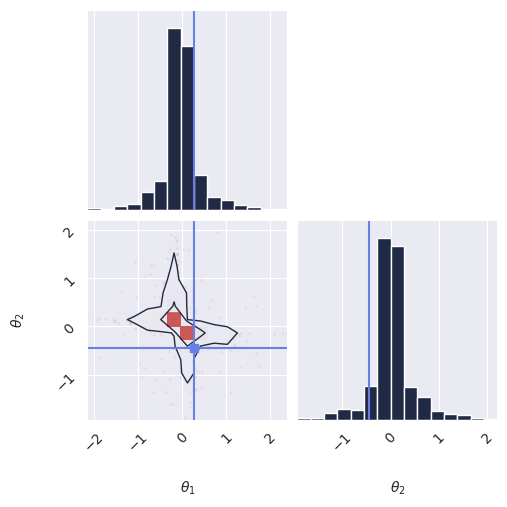

In [42]:
# plot_marginals(res, true_param=true_theta[0], gridsize=20, range=[(0.8,1.2),(0,2)])
plot_marginals(res, true_param=true_theta[:,0])
plt.show()

# Calibration tests

In [30]:
# imports
from gensbi_validation import PosteriorWrapper
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp
from sbi.analysis.plot import plot_tarp

import torch

In [ ]:
posterior = PosteriorWrapper(pipeline_latent, keys=nnx.Rngs(1234), theta_shape=(1,2), x_shape=(8192,2), encoder_key=jax.random.PRNGKey(1234))
# posterior = PosteriorWrapper(pipeline_latent, keys=nnx.Rngs(1234))

In [32]:
key = jax.random.PRNGKey(1234)
# sample the dataset
test_data = dataset["test"]

# split in thetas and xs
thetas = np.array(test_data["thetas"])[:200] # (200, 3, 1)
xs = np.array(test_data["xs"])[:200] # (200, 3, 1)

In [33]:
# flatten the dataset. sbi expects 2D arrays of shape (num_samples, features), while our data is 3D of shape (num_samples, dim, channels).
# we reshape a sample of size (dim, channels) into a vector of size (dim * channels)
thetas_ = posterior._ravel(thetas) # (200, 3)
xs_ = posterior._ravel(xs) # (200, 3)

# convert to torch tensors
thetas_torch = torch.Tensor(np.asarray(thetas_, dtype=np.float32))
xs_torch = torch.Tensor(np.asarray(xs_, dtype=np.float32))

In [34]:
ecp, alpha = run_tarp(
    thetas_torch[:20],
    xs_torch[:20],
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=100, # reduce this number to 1000 if you go OOM
)

Sampling: 100%|██████████| 2/2 [00:45<00:00, 22.67s/it]


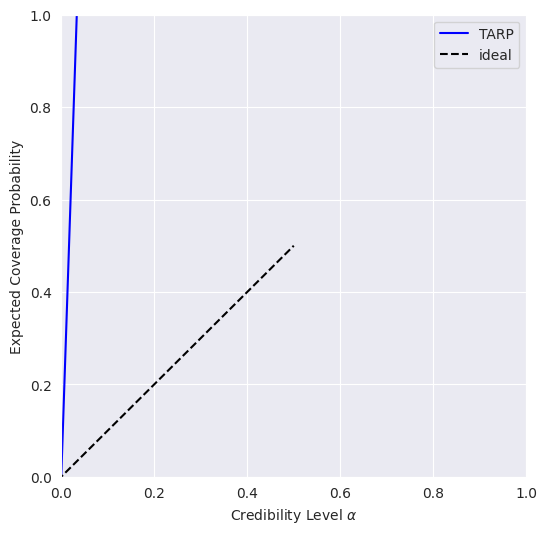

In [35]:
plot_tarp(ecp, alpha)
# plt.savefig("flux1_flow_pipeline_tarp.png", dpi=100, bbox_inches="tight") # uncomment to save the figure
plt.show()

In [36]:
print("done")

done
